# A2.2 LDA y Árboles de Decisión

En este trabajo, se analizará una base de datos histórica que contiene información sobre los pasajeros del Titanic, con el objetivo de predecir la probabilidad de supervivencia de cada uno de ellos utilizando un modelo de regresión logística. Esta técnica es adecuada, ya que la variable a predecir ("Survived") es binaria: 1 significa que el pasajero sobrevivió, y 0 que no lo hizo.

Variables utilizadas:

* Survived: Variable objetivo (0 = No sobrevivió, 1 = Sobrevivió).
* Pclass: Clase del pasajero (1 = Primera clase, 2 = Segunda clase, 3 = Tercera clase).
* Age: Edad del pasajero.
* SibSp: Número de hermanos o cónyuges a bordo.
* Parch: Número de padres o hijos a bordo.
* Fare: Tarifa pagada por el pasajero.
* Cabin_known: Indica si se conoce el número de camarote (1 = Sí, 0 = No).
* Sex_male: Género del pasajero (1 = Hombre, 0 = Mujer).
* Embarked_Q: Indica si el pasajero embarcó en el puerto Queenstown (1 = Sí, 0 = No).
* Embarked_S: Indica si el pasajero embarcó en el puerto Southampton (1 = Sí, 0 = No).
* Con estas variables, el modelo buscará patrones que permitan identificar qué tipo de pasajeros tuvieron mayor probabilidad de sobrevivir al hundimiento.

Para evaluar el desempeño del modelo de regresión logística, se realizó una separación de los datos en un conjunto de entrenamiento (80%) y un conjunto de prueba (20%). Al igual, se necesita verificar que las proporciones al dividir los datos con el fin de asegurar que la división de clases (sobrevivientes y no sobrevivientes) se mantuviera constante tanto en el conjunto de entrenamiento como en el de prueba.

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv("DataTitanic_Processed.csv")

dummyPclass = pd.get_dummies(df.Pclass, drop_first=True, dtype=int)
df = pd.concat([df, dummyPclass], axis=1)
df = df.drop(columns=['Pclass'], axis=1)

df.columns = ['Survived', 'Age', 'SibSp', 'Parch', 'Fare', 'Cabin_known', 'Sex_male', 'Embarked_Q', 'Embarked_S', 'Pclass_2', 'Pclass_3']

print("Repartición de los datos originales")
print(df.Survived.value_counts())

X = df.drop('Survived', axis=1)
y = df.Survived

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

print("\nRepartición de los datos de entrenamiento")
print(y_train.value_counts())

print("\nRepartición de los datos de prueba")
print(y_test.value_counts())



Repartición de los datos originales
Survived
0    549
1    342
Name: count, dtype: int64

Repartición de los datos de entrenamiento
Survived
0    439
1    273
Name: count, dtype: int64

Repartición de los datos de prueba
Survived
0    110
1     69
Name: count, dtype: int64


Para continuar con el análisis, se procede a entrenar un modelo de regresión logística utilizando los datos de entrenamiento y se va a mostrar un resumen del modelo.

In [2]:
import statsmodels.api as sm

# Agregar constante para la regresión
X_train_const = sm.add_constant(X_train)

# Ajustar modelo
model = sm.GLM(y_train, X_train_const, family=sm.families.Binomial()).fit()

# Mostrar resumen del modelo
print(model.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:               Survived   No. Observations:                  712
Model:                            GLM   Df Residuals:                      701
Model Family:                Binomial   Df Model:                           10
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -315.17
Date:                Wed, 19 Mar 2025   Deviance:                       630.34
Time:                        21:33:56   Pearson chi2:                     737.
No. Iterations:                     5   Pseudo R-squ. (CS):             0.3599
Covariance Type:            nonrobust                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           3.4570      0.601      5.750      

En base al resumen del modelo, podemos concluir que las 2 variables mas relavantes para el estudio son el sexo y la edad de la persona, basandonos en que son las que tienen un p-value más bajo, ya que significa son las que estamos más seguros que afectan la mayor cantidad de los datos.

In [3]:
top_vars = model.pvalues.drop('const').nsmallest(2).index.tolist()
print("\nVariables más relevantes:", top_vars)

X_train_selected = X_train[top_vars]
X_test_selected = X_test[top_vars]


Variables más relevantes: ['Sex_male', 'Age']


Se genera un modelo utilizando la metodología de LDA. Para evaluar su desempeño, se mostrará la función discriminante a través de una gráfica que representa la relación entre las dos variables más relevantes del estudio.

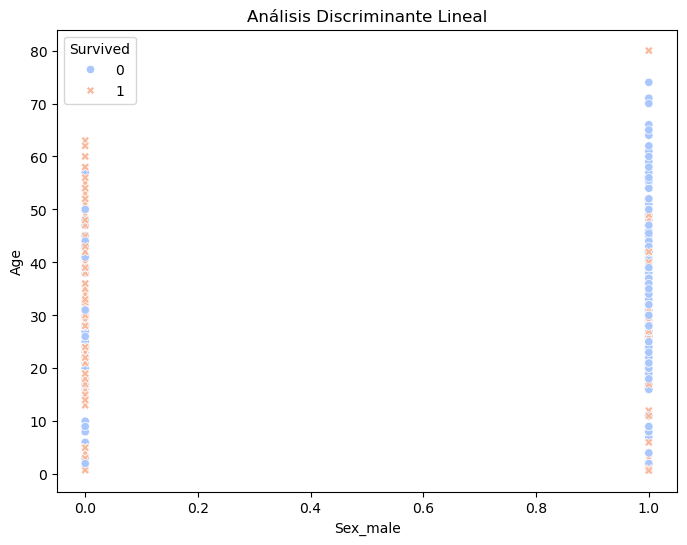

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Ajustar modelo LDA
lda = LinearDiscriminantAnalysis()
lda.fit(X_train_selected, y_train)

# Proyección de los datos en la función discriminante
X_lda = lda.transform(X_train_selected)

# Graficar
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_train_selected.iloc[:, 0], y=X_train_selected.iloc[:, 1], hue=y_train, style=y_train, palette="coolwarm")
plt.xlabel(top_vars[0])
plt.ylabel(top_vars[1])
plt.title("Análisis Discriminante Lineal")
plt.show()


En esta gráfica, podemos observar que la mayoria de los hombres no sobrevivieron y la mayoria de las mujeres mas grandes de los 10 años aproximadamente sobrevivieron.

Se construye un modelo basado en la metodología de árboles de decisión, aplicando un proceso de poda para optimizar su desempeño. Además, para determinar el valor óptimo del hiperparámetro alpha, se utilizó la metodología de validación cruzada Leave-One-Out (LOOCV), garantizando así una adecuada generalización del modelo. Posteriormente, se visualizará el árbol de decisión resultante y la partición del espacio de decisión mediante una gráfica de las dos variables.

Mejor alpha: 0.01


c:\Users\matth\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


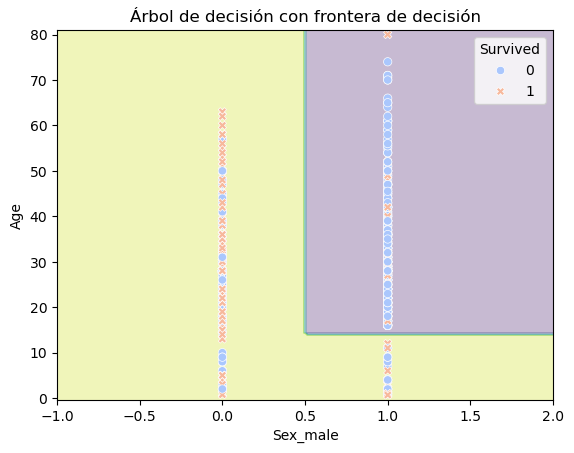

In [5]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
import numpy as np

# Definir un rango de valores de alpha
alphas = [0.0001, 0.001, 0.01, 0.1, 1, 10]
scores = []

for alpha in alphas:
    tree = DecisionTreeClassifier(ccp_alpha=alpha, random_state=42)
    score = cross_val_score(tree, X_train_selected, y_train, cv=5).mean()  # Cambié cv=len(y_train) por cv=5
    scores.append(score)

# Seleccionar el mejor α
best_alpha = alphas[scores.index(max(scores))]
print("Mejor alpha:", best_alpha)


# Entrenar el árbol con poda
tree = DecisionTreeClassifier(ccp_alpha=best_alpha, random_state=42)
tree.fit(X_train_selected, y_train)

# Graficar frontera de decisión

x_min, x_max = X_train_selected.iloc[:, 0].min() - 1, X_train_selected.iloc[:, 0].max() + 1
y_min, y_max = X_train_selected.iloc[:, 1].min() - 1, X_train_selected.iloc[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
Z = tree.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.3)
sns.scatterplot(x=X_train_selected.iloc[:, 0], y=X_train_selected.iloc[:, 1], hue=y_train, style=y_train, palette="coolwarm")
plt.xlabel(top_vars[0])
plt.ylabel(top_vars[1])
plt.title("Árbol de decisión con frontera de decisión")
plt.show()


En base a esta grafica, podemos notar que el arbol de desición dividió los datos para se espere que las mujeres sobrevivieron, al igual que los niños menores de 10 años sin importar su sexo. Por otro lado, aquellos hombres mayores a 10 años se espera que no sobrevivieran.

Se calculan diferentes métricas para evaluar el desempeño de ambos modelos utilizando los datos de prueba.

In [6]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Predicciones
y_pred_lda = lda.predict(X_test_selected)
y_pred_tree = tree.predict(X_test_selected)

# Función para imprimir métricas
def print_metrics(y_true, y_pred, model_name):
    print(f"\nMétricas para {model_name}:")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred))
    print("Recall:", recall_score(y_true, y_pred))
    print("F1-score:", f1_score(y_true, y_pred))

# Evaluar modelos
print_metrics(y_test, y_pred_lda, "LDA")
print_metrics(y_test, y_pred_tree, "Árbol de decisión")



Métricas para LDA:
Accuracy: 0.7877094972067039
Precision: 0.7313432835820896
Recall: 0.7101449275362319
F1-score: 0.7205882352941176

Métricas para Árbol de decisión:
Accuracy: 0.7821229050279329
Precision: 0.7027027027027027
Recall: 0.7536231884057971
F1-score: 0.7272727272727273


Ventajas de cada modelo
1. Análisis Discriminante Lineal (LDA)
* Mayor precisión y exactitud: LDA es más confiable cuando es crucial minimizar los falsos positivos.
* Mayor exactitud: tiene una ligera ventaja clasificando correctamente más observaciones.

2. Árbol de Decisión podado
* Mayor recall: Mejor identificando observaciones positivas y reduciendo los falsos negativos.
* Mayor F1-score: Muestra un ligero mejor balance entre precisión y sensibilidad
* Interpretabilidad visual: Se puede visualizar cómo toma decisiones en cada nivel.

En este caso, como ambos modelos tienen un desempeño similar, la elección dependerá de si es más importante minimizar falsos positivos (precision - LDA) o minimizar falsos negativos (recall - Árbol de Decisión).

Se utilizó ChatGPT para la generación del código y parte de la redacción de pasos.

**Firma de honor:** "Doy mi palabra que he realizado esta actividad con integridad académica" - Daniel Matthieu Potes Lesoinne #584678